# Host-Galaxy Association with Pröst

### This notebook shows the basics of prost for host-galaxy association.

First, let's import some relevant packages. We'll need distributions to define our priors and likelihoods.

In [1]:
import pandas as pd
from scipy.stats import gamma, halfnorm, uniform
from astropy.cosmology import LambdaCDM
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 

#pretty plotting
sns.set_context("poster")

#enable interactive plotting
%matplotlib inline

Pröst also provides a custom distribution object for the expected redshift of a transient with a given brightness and fixed volumetric rate. 

In [2]:
from astro_prost.helpers import PriorzObservedTransients, SnRateAbsmag

Next, we import the functions that do the bulk of the work.

In [3]:
from astro_prost.associate import associate_sample, prepare_catalog

Now let's read in a transient catalog, which should have at least the name and coordinates of the transients. Here, we use the [ZTF BTS](https://sites.astro.caltech.edu/ztf/bts/explorer.php?f=s&subsample=trans&classstring=&endpeakmag=19.0&purity=y&quality=y) sample.

In [4]:
transient_catalog = pd.read_csv("../../src/astro_prost/data/ZTFBTS_TransientTable.csv")

#only take the first 10 events 
transient_catalog = transient_catalog.sample(n=1)

print(transient_catalog.sample(frac=1)[['IAUID', 'RA', 'Dec']])

          IAUID           RA          Dec
3784  SN2022hbp  10:26:05.46  +18:24:44.2


Next, we define the priors for the association. By default, Pröst defines priors on a transient's observed(!)
* Redshift distribution
* Fractional radial offset from its host galaxy (defined in units of the host's [Directional Light Radius](https://arxiv.org/pdf/1604.06138))
* Host galaxy brightness, in absolute magnitude ($B$-band if associating with the glade catalog, else the median across $griz$)

We'll keep things simple for now, and assume that we detect fewer events with redshift, with broad uniform priors for brightness and fractional offset. 

In [5]:
# define priors for properties
priorfunc_z = halfnorm(loc=0.0001, scale=0.5)
priorfunc_offset = uniform(loc=0, scale=10)
priorfunc_absmag = uniform(loc=-30, scale=20)

If, instead, you want the redshift prior to be based on an observed distribution of transients within a given absolute magnitude range, 
we can build an empirical distribution by uniformly distributed transients in a cosmological volume between $z_{min}$ and $z_{max}$, and call 
the the subset with peak brightness above $mag_{cutoff}$ to be "observed". 

By default, the code draws a transient's peak brightness from a truncated gaussian from $absmag_{min}$ to $absmag_{max}$, with mean of $absmag_{mean}$. 

In [6]:
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
priorfunc_z = PriorzObservedTransients(z_min=0, z_max=1, mag_cutoff=19, absmag_mean=-19, absmag_min=-24, absmag_max=-17, cosmo=cosmo)

We can then plot the resulting distribution:

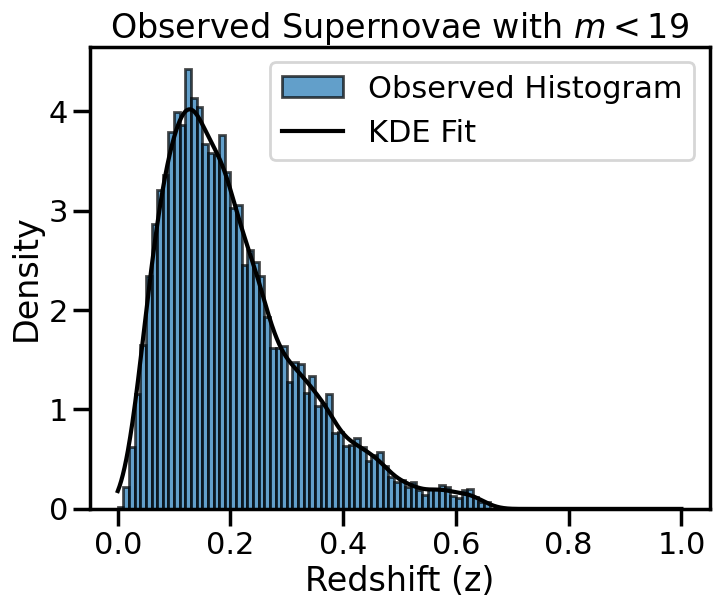

In [7]:
#broken for now
priorfunc_z.plot()

The pdf of the distribution can be evaluated and sampled:

In [8]:
z_samples = priorfunc_z.rvs(10)
print(z_samples)

[0.03728324 0.4201151  0.10974676 0.34332886 0.16869762 0.18380108
 0.04250936 0.32227555 0.09994476 0.23941398]


In [9]:
priorfunc_z.pdf(z_samples)

array([1.35490787, 0.65802026, 3.90013298, 1.22448805, 3.65845961,
       3.47722784, 1.60150406, 1.36709914, 3.73867818, 2.48296636])

Next, we set the likelihoods. Note that we only set these for fractional offset and brightness; the redshift likelihood comes from comparing the photometric redshifts of candidate galaxies with the redshift of the transient (if available). 

In [10]:
likefunc_offset = gamma(a=0.75)
likefunc_absmag = SnRateAbsmag(a=-25, b=20)

priors = {"offset": priorfunc_offset, "absmag": priorfunc_absmag, "z": priorfunc_z}
likes = {"offset": likefunc_offset, "absmag": likefunc_absmag}

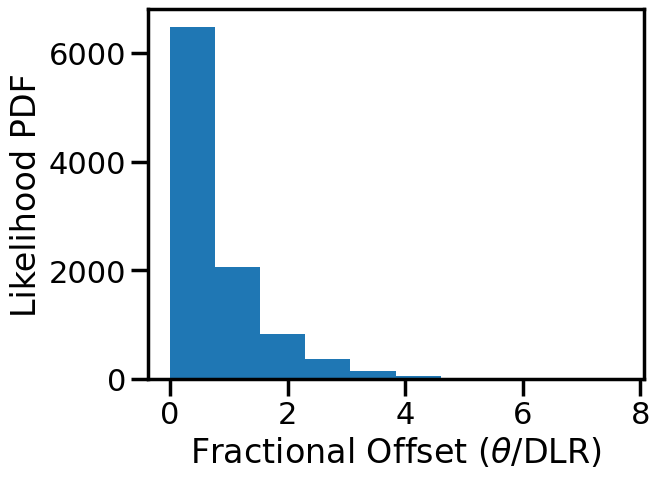

In [11]:
plt.hist(likefunc_offset.rvs(size=10000));
plt.xlabel(r"Fractional Offset ($\theta$/DLR)");
plt.ylabel("Likelihood PDF");

Our likelihood for fractional offset sharply peaks near 0: if a transient is sitting on top of a galaxy, odds are very good that it's the host. The likelihood for host galaxy brightness is set here to a supernova-based likelihood, which increases with absolute magnitude.

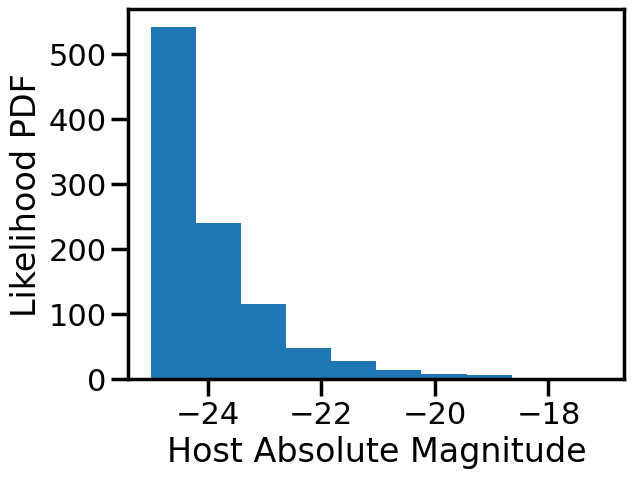

In [12]:
plt.hist(likefunc_absmag.rvs(size=1000))
plt.xlabel(r"Host Absolute Magnitude");
plt.ylabel("Likelihood PDF");

Next, let's set up the properties of the run:

In [13]:
# list of catalogs to search -- options are (in order) glade, decals, panstarrs
# If multiple are listed, the code stops whenever it finds a high-probability host
catalogs = ["panstarrs"]

# The name of the coordinate columns in the dataframe
# Can be in string hourangle, deg or decimal degrees
transient_coord_cols = ("RA", "Dec")

# the column corresponding to transient names
transient_name_col = "IAUID"

# can be 0, 1, or 2
verbose = 1

# If true, enables multiprocessing with mpire (cannot be run in this notebook)
parallel = False

# If true, saves the results of the run to disk (alternative is to return them directly)
save = False

# If true, shows a progress bar for each association (only available when parallel=True)
progress_bar = False

# If true, concatenates the source properties from the matched catalog to the returned results
cat_cols = True

In [14]:
transient_catalog = prepare_catalog(
    transient_catalog, transient_name_col=transient_name_col, transient_coord_cols=transient_coord_cols
)

# cosmology can be specified, else flat lambdaCDM is assumed with H0=70, Om0=0.3, Ode0=0.7
transient_catalog_with_hosts = \
    associate_sample(
        transient_catalog,
        priors=priors,
        likes=likes,
        catalogs=catalogs,
        parallel=parallel,
        verbose=verbose,
        save=save,
        progress_bar=progress_bar,
        cat_cols=cat_cols,
)

Associating SN2022hbp at RA, DEC = 156.522750, 18.412278
Removing panstarrs shreds.
Removed 11 flagged panstarrs sources.
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Association successful!
Found a good host in panstarrs!
Chosen galaxy has catalog ID of 130091565226225235 and RA, DEC = 156.522684, 18.412273
host_id
host_2_id
uniquePspsOBid
uniquePspsSTid
Association of all transients is complete.


In [16]:
transient_catalog_with_hosts

Let's look at the results: 

In [15]:
transient_catalog_with_hosts[['IAUID', 'host_id', 'host_ra', 'host_dec', 'host_prob', 'smallcone_prob', 'missedcat_prob']]

TypeError: 'NoneType' object is not subscriptable